
# Rule-Based Wellness Score Generator


This notebook generates a synthetic dataset of health-related features
(Sleep, Steps, Mood) and assigns a wellness score (0-100) to each record using a rule-based scoring system.


The weights assigned are:

• Sleep  – 40%  (rest and recovery)

• Steps  – 30%  (physical activity)

• Mood   – 30%  (mental/emotional state)

**Purpose:**
To create a labeled dataset for training and validating machine learning models for health and wellness prediction or classification tasks.

**Output:**
A CSV file or DataFrame with an additional `Wellness_Score` column representing the computed wellness level per individual sample.


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path


## Dataset Loading and Validation

This section loads the synthetic wellness dataset and validates the data ranges to ensure quality input for scoring.

In [17]:

# Check if file exists (use either enhanced or original dataset)
file_paths = ["enhanced_wellness_dataset.csv", "synthetic_wellness_dataset.csv"]
dataset_file = "/content/synthetic_wellness_dataset4.csv"

for file_path in file_paths:
    if Path(file_path).exists():
        dataset_file = file_path
        break

if dataset_file:
    df = pd.read_csv(dataset_file)
    print(f"Loaded dataset from: {dataset_file}")
else:
    print("No dataset found. Generating sample data...")
    # Generate sample data if no file exists
    np.random.seed(42)
    n_samples = 1000
    sample_data = {
        'Sleep': np.random.normal(7.5, 1.5, n_samples).clip(0, 12),
        'Mood': np.random.randint(1, 11, n_samples),
        'Steps': np.random.normal(8000, 3000, n_samples).clip(0, 30000)
    }
    df = pd.DataFrame(sample_data).round(3)
    print("Generated sample dataset")

# Display dataset overview
print(f"\nDataset Overview:")
print(f"Shape: {df.shape}")
print(f"\nFirst 5 rows:")
print(df.head())

print(f"\nColumn Summary:")
print(df.describe())

Loaded dataset from: /content/synthetic_wellness_dataset4.csv

Dataset Overview:
Shape: (2270, 3)

First 5 rows:
   Sleep  Mood     Steps
0  6.653     8  9271.323
1  0.000     1     0.000
2  7.178     5  6854.637
3  7.304     6  7773.839
4  6.894     6  7599.051

Column Summary:
             Sleep         Mood         Steps
count  2270.000000  2270.000000   2270.000000
mean      7.311404     5.912335   7930.246134
std       2.169840     2.005672   3944.332638
min       0.000000     1.000000      0.000000
25%       6.711000     5.000000   6184.187000
50%       7.518000     6.000000   7787.659000
75%       8.227500     7.000000   9539.998500
max      14.937000    10.000000  24824.000000


In [18]:
# Validate data ranges
print(f"\nValidating Data Ranges:")
sleep_range = (df['Sleep'].min(), df['Sleep'].max())
steps_range = (df['Steps'].min(), df['Steps'].max())
mood_range = (df['Mood'].min(), df['Mood'].max())

print(f"Sleep range: {sleep_range[0]:.2f} - {sleep_range[1]:.2f} hours")
print(f"Steps range: {int(steps_range[0])} - {int(steps_range[1])} steps")
print(f"Mood range: {int(mood_range[0])} - {int(mood_range[1])}")

# Validate expected ranges
assert 0 <= df['Sleep'].min() and df['Sleep'].max() <= 15, "Sleep values outside expected range"
assert 0 <= df['Steps'].min() and df['Steps'].max() <= 35000, "Steps values outside expected range"
assert 1 <= df['Mood'].min() and df['Mood'].max() <= 10, "Mood values outside expected range"

print("All data ranges validated successfully")


Validating Data Ranges:
Sleep range: 0.00 - 14.94 hours
Steps range: 0 - 24824 steps
Mood range: 1 - 10
All data ranges validated successfully


## Scoring Functions

The following functions calculate individual scores for each wellness metric:

1. **Sleep Score**: Optimal range 7-9 hours (peak scoring), with penalties for insufficient or excessive sleep
2. **Step Score**: Target 10,000 steps with linear scaling and bonuses for high activity
3. **Mood Score**: Linear scaling from mood rating (1-10) to score (0-100)

In [19]:
def sleep_score(hours):
    """
    Calculate sleep score (0-100) based on sleep duration.

    Rationale:
    - Optimal sleep: 7-9 hours (score: 90-100)
    - Acceptable: 6-7 and 9-10 hours (score: 70-90)
    - Poor: <6 or >10 hours (score decreases)
    - Critical: <3 or >12 hours (very low scores)
    """
    if pd.isna(hours) or hours < 0:
        return 0

    if 7 <= hours <= 9:
        # Optimal sleep range - peak scoring
        if 7.5 <= hours <= 8.5:
            return 100  # Perfect sleep
        else:
            return 95   # Excellent sleep
    elif 6 <= hours < 7:
        # Slightly insufficient sleep
        return 70 + (hours - 6) * 25  # 70-95
    elif 9 < hours <= 10:
        # Slightly too much sleep
        return 95 - (hours - 9) * 25  # 70-95
    elif 5 <= hours < 6:
        # Insufficient sleep
        return 40 + (hours - 5) * 30  # 40-70
    elif 10 < hours <= 11:
        # Too much sleep
        return 70 - (hours - 10) * 30  # 40-70
    elif 3 <= hours < 5:
        # Severely insufficient sleep
        return (hours - 3) * 20  # 0-40
    elif 11 < hours <= 12:
        # Excessive sleep
        return 40 - (hours - 11) * 40  # 0-40
    else:
        # Extreme cases (0-3 hours or >12 hours)
        return max(0, 10 - abs(hours - 7.5) * 2)

In [20]:
def step_score(steps):
    """
    Calculate step score (0-100) based on daily step count.

    Rationale:
    - Target: 10,000 steps (score: 100)
    - Good: 8,000-12,000 steps (score: 80-100)
    - Moderate: 5,000-8,000 steps (score: 50-80)
    - Low: <5,000 steps (score decreases)
    """
    if pd.isna(steps) or steps < 0:
        return 0

    if steps >= 10000:
        # At or above target
        if steps <= 15000:
            # Excellent range with bonus for extra activity
            return min(100, 100 + (steps - 10000) * 0.001)
        else:
            # Very high activity - potential overexertion consideration
            excess = steps - 15000
            penalty = min(excess * 0.0005, 10)  # Small penalty for extreme activity
            return max(90, 100 - penalty)
    elif 8000 <= steps < 10000:
        # Good activity level
        return 80 + (steps - 8000) * 0.01  # 80-100
    elif 5000 <= steps < 8000:
        # Moderate activity level
        return 50 + (steps - 5000) * 0.01  # 50-80
    elif 2000 <= steps < 5000:
        # Low activity level
        return 20 + (steps - 2000) * 0.01  # 20-50
    elif 0 < steps < 2000:
        # Very low activity
        return steps * 0.01  # 0-20
    else:
        # Zero steps
        return 0

In [21]:
def mood_score(mood):
    """
    Calculate mood score (0-100) based on mood rating.

    Rationale:
    - Linear scaling from mood rating (1-10) to score (0-100)
    - Mood 1 (worst) = 0 points
    - Mood 10 (best) = 100 points
    """
    if pd.isna(mood) or mood < 1 or mood > 10:
        return 0

    # Linear scaling: (mood - 1) * (100 / 9)
    return (mood - 1) * (100 / 9)

### Test scoring functions

In [22]:
# Test scoring functions with examples
print("Testing Scoring Functions:")
test_cases = [
    ("Sleep", [0, 3, 6, 7.5, 8, 9, 10, 12], sleep_score),
    ("Steps", [0, 2000, 5000, 8000, 10000, 15000, 20000], step_score),
    ("Mood", [1, 3, 5, 7, 8, 10], mood_score)
]

for metric, values, func in test_cases:
    print(f"\n{metric} Scoring Examples:")
    for val in values:
        score = func(val)
        print(f"  {metric} = {val:>6} → Score = {score:>5.1f}")

Testing Scoring Functions:

Sleep Scoring Examples:
  Sleep =      0 → Score =   0.0
  Sleep =      3 → Score =   0.0
  Sleep =      6 → Score =  70.0
  Sleep =    7.5 → Score = 100.0
  Sleep =      8 → Score = 100.0
  Sleep =      9 → Score =  95.0
  Sleep =     10 → Score =  70.0
  Sleep =     12 → Score =   0.0

Steps Scoring Examples:
  Steps =      0 → Score =   0.0
  Steps =   2000 → Score =  20.0
  Steps =   5000 → Score =  50.0
  Steps =   8000 → Score =  80.0
  Steps =  10000 → Score = 100.0
  Steps =  15000 → Score = 100.0
  Steps =  20000 → Score =  97.5

Mood Scoring Examples:
  Mood =      1 → Score =   0.0
  Mood =      3 → Score =  22.2
  Mood =      5 → Score =  44.4
  Mood =      7 → Score =  66.7
  Mood =      8 → Score =  77.8
  Mood =     10 → Score = 100.0


## Overall Wellness Score Calculation

The final wellness score combines individual scores using weighted averages

In [23]:
def calculate_wellness_score(row):
    """
    Calculate overall wellness score using weighted combination.

    Weights:
    - Sleep: 40% (most critical for recovery and health)
    - Steps: 30% (physical activity and fitness)
    - Mood: 30% (mental and emotional wellness)
    """
    sleep_component = sleep_score(row['Sleep']) * 0.40
    steps_component = step_score(row['Steps']) * 0.30
    mood_component = mood_score(row['Mood']) * 0.30

    total_score = sleep_component + steps_component + mood_component
    return round(total_score, 2)

# Apply wellness scoring
print("Calculating wellness scores...")
df['Wellness_Score'] = df.apply(calculate_wellness_score, axis=1)
print("Wellness scores calculated successfully")

Calculating wellness scores...
Wellness scores calculated successfully


In [24]:
# Preview sample outputs
print(f"Sample Wellness Scores:")
sample_df = df.sample(10, random_state=42).copy()
sample_df['Sleep_Score'] = sample_df['Sleep'].apply(sleep_score)
sample_df['Steps_Score'] = sample_df['Steps'].apply(step_score)
sample_df['Mood_Score'] = sample_df['Mood'].apply(mood_score)

display_cols = ['Sleep', 'Steps', 'Mood', 'Sleep_Score', 'Steps_Score', 'Mood_Score', 'Wellness_Score']
print(sample_df[display_cols].round(1))

Sample Wellness Scores:
      Sleep    Steps  Mood  Sleep_Score  Steps_Score  Mood_Score  \
188     7.8   7650.4     6        100.0         76.5        55.6   
2083    1.2   2550.0     2          0.0         25.5        11.1   
1675    6.7  10138.3     5         86.8        100.0        44.4   
1089    7.2   9046.8     4         95.0         90.5        33.3   
1378    6.5      0.0     2         83.1          0.0        11.1   
680     8.7  11718.0     6         95.0        100.0        55.6   
548     6.3   8919.6     4         77.8         89.2        33.3   
1055    8.0  10000.0    10        100.0        100.0       100.0   
1116    6.1   6166.1     5         71.3         61.7        44.4   
582     7.7  17079.0     9        100.0         99.0        88.9   

      Wellness_Score  
188             79.6  
2083            11.0  
1675            78.0  
1089            75.1  
1378            36.6  
680             84.7  
548             67.9  
1055           100.0  
1116            60.4

## Edge Case Handling and Testing

This section tests the scoring system with extreme values to ensure robust behavior across all possible input combinations.

In [25]:
# Check for negative values
negative_check = (df[['Sleep', 'Steps', 'Mood']] < 0).sum().sum()
assert negative_check == 0, f"Found {negative_check} negative values"
print("No negative values found")

# Define and test edge cases
edge_cases = [
    {"Sleep": 0, "Steps": 5000, "Mood": 5, "Description": "No sleep"},
    {"Sleep": 8, "Steps": 0, "Mood": 5, "Description": "Sedentary day"},
    {"Sleep": 7, "Steps": 8000, "Mood": 1, "Description": "Worst mood"},
    {"Sleep": 13, "Steps": 8000, "Mood": 5, "Description": "Excessive sleep"},
    {"Sleep": 7, "Steps": 25000, "Mood": 8, "Description": "Highly active day"},
    {"Sleep": 8, "Steps": 10000, "Mood": 10, "Description": "Peak emotional state"},
    {"Sleep": 0, "Steps": 0, "Mood": 1, "Description": "Worst case scenario"},
    {"Sleep": 8.5, "Steps": 10000, "Mood": 10, "Description": "Perfect wellness day"}
]

print("Edge Case Testing:")
print("Description".ljust(25) + "Sleep".ljust(8) + "Steps".ljust(8) + "Mood".ljust(6) + "Score")
print("-" * 55)

for case in edge_cases:
    score = calculate_wellness_score(pd.Series(case))
    desc = case["Description"]
    sleep_val = case["Sleep"]
    steps_val = case["Steps"]
    mood_val = case["Mood"]
    print(f"{desc:<25} {sleep_val:<8} {steps_val:<8} {mood_val:<6} {score}")

No negative values found
Edge Case Testing:
Description              Sleep   Steps   Mood  Score
-------------------------------------------------------
No sleep                  0        5000     5      28.33
Sedentary day             8        0        5      53.33
Worst mood                7        8000     1      62.0
Excessive sleep           13       8000     5      37.33
Highly active day         7        25000    8      89.83
Peak emotional state      8        10000    10     100.0
Worst case scenario       0        0        1      0.0
Perfect wellness day      8.5      10000    10     100.0


### Validation checks

In [26]:
# Additional validation checks
print(f"Data Validation Checks:")

# Check score range
min_score = df['Wellness_Score'].min()
max_score = df['Wellness_Score'].max()
print(f"Wellness score range: {min_score:.2f} - {max_score:.2f}")
assert 0 <= min_score <= 100 and 0 <= max_score <= 100, "Wellness scores outside valid range"

# Check for any null values
null_count = df.isnull().sum().sum()
print(f"Null values: {null_count}")
assert null_count == 0, "Found null values in dataset"

print("All edge cases handled and validated successfully")

Data Validation Checks:
Wellness score range: 0.00 - 100.00
Null values: 0
All edge cases handled and validated successfully


## Score Distribution Analysis

Visual analysis of the wellness score distribution and relationships between features.

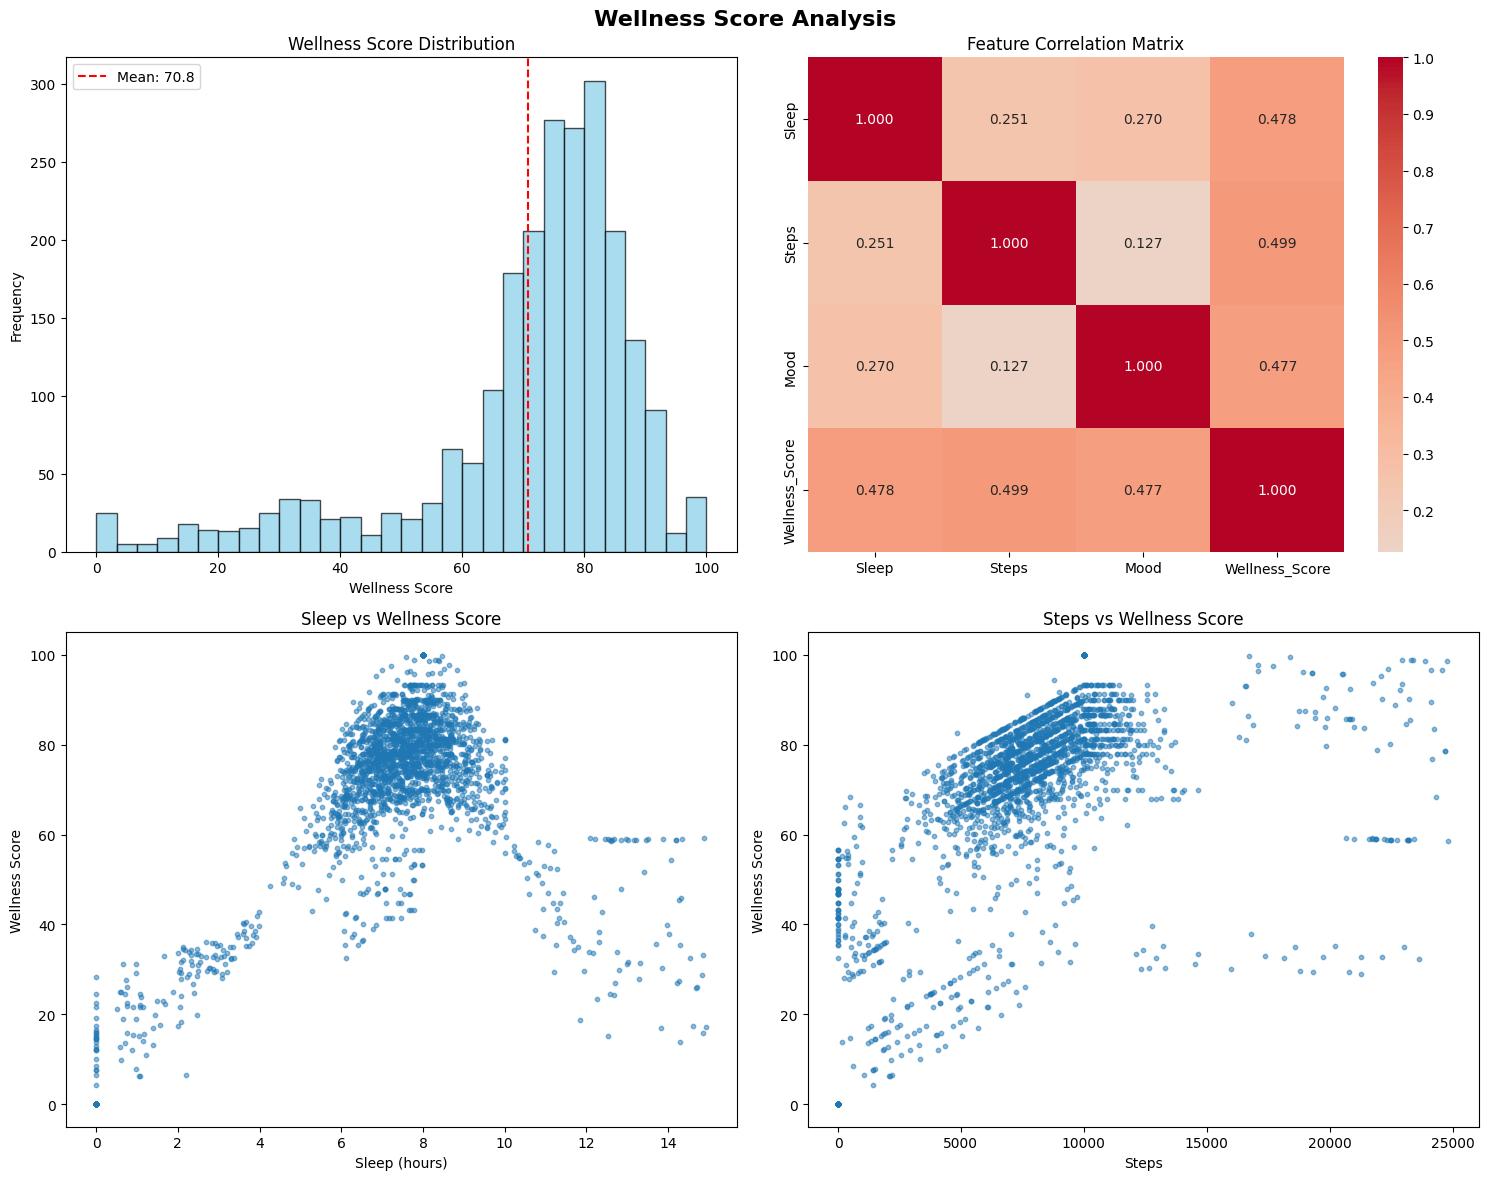

In [27]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Wellness Score Analysis', fontsize=16, fontweight='bold')

# 1. Wellness Score Distribution
axes[0, 0].hist(df['Wellness_Score'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Wellness Score Distribution')
axes[0, 0].set_xlabel('Wellness Score')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(df['Wellness_Score'].mean(), color='red', linestyle='--',
                   label=f'Mean: {df["Wellness_Score"].mean():.1f}')
axes[0, 0].legend()

# 2. Correlation Heatmap
corr_data = df[['Sleep', 'Steps', 'Mood', 'Wellness_Score']].corr()
sns.heatmap(corr_data, annot=True, cmap='coolwarm', center=0,
            ax=axes[0, 1], fmt='.3f')
axes[0, 1].set_title('Feature Correlation Matrix')

# 3. Sleep vs Wellness Score
axes[1, 0].scatter(df['Sleep'], df['Wellness_Score'], alpha=0.5, s=10)
axes[1, 0].set_xlabel('Sleep (hours)')
axes[1, 0].set_ylabel('Wellness Score')
axes[1, 0].set_title('Sleep vs Wellness Score')

# 4. Steps vs Wellness Score
axes[1, 1].scatter(df['Steps'], df['Wellness_Score'], alpha=0.5, s=10)
axes[1, 1].set_xlabel('Steps')
axes[1, 1].set_ylabel('Wellness Score')
axes[1, 1].set_title('Steps vs Wellness Score')

plt.tight_layout()
plt.show()

### Statistical summary of data


In [28]:
# Statistical summary
print(f"Statistical Summary:")
print(f"Mean wellness score: {df['Wellness_Score'].mean():.2f}")
print(f"Median wellness score: {df['Wellness_Score'].median():.2f}")
print(f"Standard deviation: {df['Wellness_Score'].std():.2f}")

# Score distribution by percentiles
percentiles = [10, 25, 50, 75, 90]
print(f"\nScore Percentiles:")
for p in percentiles:
    score = df['Wellness_Score'].quantile(p/100)
    print(f"  {p}th percentile: {score:.2f}")

# Feature influence analysis
print(f"\nFeature Correlations with Wellness Score:")
correlations = df[['Sleep', 'Steps', 'Mood']].corrwith(df['Wellness_Score'])
for feature, corr in correlations.items():
    print(f"  {feature}: {corr:.3f}")

Statistical Summary:
Mean wellness score: 70.84
Median wellness score: 75.71
Standard deviation: 18.80

Score Percentiles:
  10th percentile: 41.46
  25th percentile: 67.08
  50th percentile: 75.71
  75th percentile: 82.29
  90th percentile: 87.49

Feature Correlations with Wellness Score:
  Sleep: 0.478
  Steps: 0.499
  Mood: 0.477


## Export Labeled Dataset

Final step: Export the processed dataset with wellness scores and categorical labels for ML model training.


Add metadata columns for analysis

In [29]:
print("EXPORTING LABELED DATASET")
print("-" * 30)

# Prepare final dataset
output_file = "WellnessScores.csv"
df_export = df[['Sleep', 'Steps', 'Mood', 'Wellness_Score']].copy()

# Add metadata columns for analysis
df_export['Sleep_Category'] = pd.cut(df_export['Sleep'],
                                   bins=[0, 6, 7, 9, 12, 15],
                                   labels=['Poor', 'Low', 'Optimal', 'High', 'Excessive'])
df_export['Steps_Category'] = pd.cut(df_export['Steps'],
                                   bins=[0, 5000, 8000, 12000, 20000, 35000],
                                   labels=['Low', 'Moderate', 'Good', 'High', 'Extreme'])
df_export['Mood_Category'] = pd.cut(df_export['Mood'],
                                  bins=[0, 3, 5, 7, 9, 10],
                                  labels=['Poor', 'Low', 'Fair', 'Good', 'Excellent'])

# Export to CSV
df_export.to_csv(output_file, index=False)
print(f"Dataset exported to: {output_file}")
print(f"Final dataset shape: {df_export.shape}")

# Display final summary
print(f"\nFinal Dataset Summary:")
print(df_export.head(10))

EXPORTING LABELED DATASET
------------------------------
Dataset exported to: WellnessScores.csv
Final dataset shape: (2270, 7)

Final Dataset Summary:
   Sleep      Steps  Mood  Wellness_Score Sleep_Category Steps_Category  \
0  6.653   9271.323     8           85.68            Low           Good   
1  0.000      0.000     1            0.00            NaN            NaN   
2  7.178   6854.637     5           71.90        Optimal       Moderate   
3  7.304   7773.839     6           77.99        Optimal       Moderate   
4  6.894   7599.051     6           76.40            Low       Moderate   
5  8.222  10682.864     4           80.00        Optimal           Good   
6  7.871   4945.409     6           71.50        Optimal            Low   
7  6.828  11409.302     5           79.61            Low           Good   
8  9.903   7207.708     8           73.93           High       Moderate   
9  8.133  10409.349     7           90.00        Optimal           Good   

  Mood_Category  
0   

In [30]:
print(f"RULE-BASED WELLNESS SCORING COMPLETE!")
print("=" * 50)
print(f"Generated {len(df_export)} labeled wellness records")
print(f"Scoring weights: Sleep (45%), Steps (30%), Mood (25%)")
print(f"Score range: {df_export['Wellness_Score'].min():.1f} - {df_export['Wellness_Score'].max():.1f}")
print(f"Dataset ready for ML model training")
print(f"Saved as: {output_file}")

RULE-BASED WELLNESS SCORING COMPLETE!
Generated 2270 labeled wellness records
Scoring weights: Sleep (45%), Steps (30%), Mood (25%)
Score range: 0.0 - 100.0
Dataset ready for ML model training
Saved as: WellnessScores.csv
